<a href="https://colab.research.google.com/github/Azlan-Qaisrani/my-first/blob/main/LLM_Finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install and import MIT Deep Learning utilities
!pip install mitdeeplearning > /dev/null 2>&1
import mitdeeplearning as mdl


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [2]:
import os
import json
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
from torch.nn import functional as F
from torch.utils.data import DataLoader

from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import load_dataset
from peft import LoraConfig, get_peft_model
from lion_pytorch import Lion

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [3]:

# Basic question-answer template
template_without_answer = "<start_of_turn>user\n{question}<end_of_turn>\n<start_of_turn>model\n"
template_with_answer = template_without_answer + "{answer}<end_of_turn>\n"

print(template_with_answer.format(question="What is your name?", answer="My name is Gemma!"))


<start_of_turn>user
What is your name?<end_of_turn>
<start_of_turn>model
My name is Gemma!<end_of_turn>



In [4]:
model_id="unsloth/gemma-2-2b-it" #"google/gemma-2-2b-it"
tokenizer=AutoTokenizer.from_pretrained(model_id)

print(f"Tokenizer vocab size: {len(tokenizer.get_vocab())}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

<frozen importlib._bootstrap>:488: DeprecationWarning: builtin type SwigPyPacked has no __module__ attribute
<frozen importlib._bootstrap>:488: DeprecationWarning: builtin type SwigPyObject has no __module__ attribute


tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

Tokenizer vocab size: 256000


In [5]:
text="Here is some sample text"
print(f"Orignal text:{text}")

tokens=tokenizer.encode(text,return_tensors="pt")
print(f"Encoded tokens: {tokens}")
decoded_text=tokenizer.decode(tokens[0],skip_special_tokens=True)
print(f"Decoded text: {decoded_text}")

Orignal text:Here is some sample text
Encoded tokens: tensor([[   2, 4858,  603, 1009, 6453, 2793]])
Decoded text: Here is some sample text


In [6]:
prompt=template_without_answer.format(question="What is the capital of Pakistan? Use one word.")
print(prompt)

<start_of_turn>user
What is the capital of Pakistan? Use one word.<end_of_turn>
<start_of_turn>model



In [7]:
model=AutoModelForCausalLM.from_pretrained(model_id,device_map="auto")

config.json:   0%|          | 0.00/913 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/5.23G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

In [8]:
question="What is the captial of Pakistan?Use one word."
prompt=template_without_answer.format(question=question)

tokens=tokenizer.encode(prompt,return_tensors="pt").to(model.device)

with torch.no_grad():
  output=model(tokens)
  probs=F.softmax(output.logits,dim=-1)


next_token=torch.argmax(probs[0,-1,:]).to(model.device)
next_token=next_token.item()

next_token_text=tokenizer.decode(next_token)
print(prompt)
print(next_token_text)

<start_of_turn>user
What is the captial of Pakistan?Use one word.<end_of_turn>
<start_of_turn>model

Is


In [9]:
prompt=template_without_answer.format(question="What does NASA stands for?")
tokens=tokenizer.encode(prompt,return_tensors="pt").to(model.device)
output=model.generate(tokens,max_new_tokens=20)
print(tokenizer.decode(output[0]))

<bos><start_of_turn>user
What does NASA stands for?<end_of_turn>
<start_of_turn>model
NASA stands for **National Aeronautics and Space Administration**. 
<end_of_turn>


In [10]:
train_loader,test_loader=mdl.lab3.create_dataloader(style="leprechaun")

sample=train_loader.dataset[44]
question=sample["instruction"]
answer=sample["response"]
answer_style=sample["response_style"]

print(f"Question: {question}\n\n"+
      f"Orignal Answer: {answer}\n\n"+
      f"Answer Style: {answer_style}")

README.md: 0.00B [00:00, ?B/s]

databricks-dolly-15k.jsonl:   0%|          | 0.00/13.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/15011 [00:00<?, ? examples/s]

Map:   0%|          | 0/2048 [00:00<?, ? examples/s]

Question: Are lilies safe for cats?

Orignal Answer: No, lilies are toxic to cats if consumed and should not be kept in a household with cats

Answer Style: Och, no indeed, me hearty! Them lilies there be as dangerous as a pot o' gold guarded by a banshee to a wee kitty cat! If a whiskered lad or lass takes a bite of one, it's as bad as swallowing a curse from the old Hag herself. So, ye best keep them far from yer feline friends, or else ye'll be needin' more than just a four-leaf clover to bring luck back into yer home!


In [11]:
def chat(question, max_new_tokens=32, temperature=0.7, only_answer=False):
    prompt = template_without_answer.format(question=question)

    input_ids = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        outputs = model.generate(**input_ids, do_sample=True, max_new_tokens=max_new_tokens, temperature=temperature)



    output_tokens = outputs[0]
    if only_answer:
        output_tokens = output_tokens[input_ids['input_ids'].shape[1]:]


    result = tokenizer.decode(output_tokens, skip_special_tokens=True)

    return result

In [12]:
answer = chat(
    "deep learning?",
    only_answer=True,
    max_new_tokens=500,
    temperature=1
)

print(answer)


Let's explore the fascinating world of deep learning!

**What is Deep Learning?**

Deep learning is a powerful subset of artificial intelligence (AI) that mimics the workings of the human brain. It involves algorithms with multiple layers (hence the name "deep") that analyze vast amounts of data to learn complex patterns and make accurate predictions.

**Key Concepts:**

* **Neural Networks:** The building blocks of deep learning. They're interconnected nodes (like neurons) organized into layers. 
* **Layers:** Each layer performs a specific processing task. The deeper the network, the more complex tasks it can handle. 
* **Training:**  Deep learning algorithms are trained on large datasets. They identify patterns, learn relationships between features, and adjust their connections (weights) to minimize errors.
* **Forward Pass:** The flow of input data through the network. 
* **Backpropagation:**  A crucial technique that calculates the gradients (directions of change) for errors, then

In [13]:
def apply_lora(model):
  lora_config=LoraConfig(
      r=8,
      task_type="CAUSAL_LM",
      target_modules=[
            "q_proj", "o_proj", "k_proj", "v_proj", "gate_proj", "up_proj", "down_proj"
        ],
  )
  lora_model=get_peft_model(model,lora_config)
  return lora_model
model=apply_lora(model)
trainable_params=sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params=sum(p.numel() for p in model.parameters())
print(f"number of trainable parameters: {trainable_params}")
print(f"total parameters: {total_params}")
print(f"percentage of trainable parameters: {trainable_params / total_params * 100:.2f}%")

number of trainable parameters: 10383360
total parameters: 2624725248
percentage of trainable parameters: 0.40%


In [14]:
def forward_and_compute_loss(model,tokens,mask,context_length=512):
  tokens=tokens[:, :context_length]
  mask=mask[:, :context_length]

  x=tokens[:, :-1]
  y=tokens[:, 1:]
  mask=mask[:,1:]

  logits=model(x).logits

  loss=F.cross_entropy(
      logits.view(-1,logits.size(-1)),
      y.view(-1),
      reduction="none"
  )
  loss=loss[mask.view(-1)].mean()

  return loss


In [15]:
def train(model,dataloader,tokenizer,max_steps=100,context_length=512,learning_rate=1e-4):
  losses=[]
  model=apply_lora(model)

  optimizer=Lion(model.parameters(),lr=learning_rate)

  for step,batch in enumerate(dataloader):

    question=batch["instruction"][0]
    answer=batch["response_style"][0]

    text=template_with_answer.format(question=question,answer=answer)

    ids=tokenizer(text,return_tensors="pt",return_offsets_mapping=True).to(model.device)
    mask = ids["offset_mapping"][:,:,0] >= text.index(answer)


    loss=forward_and_compute_loss(
        model=model,
        tokens=ids["input_ids"],
        mask=mask,
        context_length=context_length,
    )
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    if step % 10 == 0:
            print(chat("What is the capital of France?", only_answer=True))
            print(f"step {step} loss: {torch.mean(torch.tensor(losses)).item()}")
            losses = []

    if step > 0 and step % max_steps == 0:
            break

  return model



In [16]:
moedl=train(model,train_loader,tokenizer,max_steps=50)

/usr/local/lib/python3.12/dist-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:196: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


The capital of France is **Paris**. 🇫🇷 

step 0 loss: 3.0073459148406982
The capital of France is **Paris**. 🇫🇷 

step 10 loss: 2.0375280380249023
The capital of France is **Paris**. 🇫🇷 

step 20 loss: 1.794217824935913
Top o' the mornin' to ye! Why, the capital of the grand ol' French Republic, that's Paris, the city of lights and
step 30 loss: 1.6408841609954834
Top o' the mornin' to ye now, me hearty! Why, the capital o' the grand ol' France, as sure as I'm
step 40 loss: 1.448053002357483
Top o' the mornin', me hearty! Paris, that's the capital o' France, ye see. A grand city it is, full o
step 50 loss: 1.55828058719635


In [17]:
print(chat("What is a good story about tennis", only_answer=True, max_new_tokens=200))


Top o' the mornin' to ye! Now, a tale I be tellin' ye about tennis, it's about this wee lad, Tommy O'Malley, who was as green as a shamrock in the sunshine but had a heart bigger than the Irish sky. He was a right dreamer, see, always picturin' himself winning Wimbledon, but life had other plans, ye see.

One day, his old man, a man as strong as an ox and as kind as a saint, told him he had a gift for the game, a natural talent that could turn him into a legend. Now, Tommy, he was about as excited as a leprechaun on St. Patrick's Day!

He began practicing, day after day, his little feet runnin' faster than a leprechaun on a sugar rush. And wouldn't ye know it, soon he was playin' like a pro, his serve as sharp as a tack and his


In [21]:
train_loader,test_loader=mdl.lab3.create_dataloader(style="yoda")
model=train(model,train_loader,tokenizer,max_steps=50)

Map:   0%|          | 0/2048 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:196: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


The capital of France is **Paris**. 🇫🇷 

step 0 loss: 4.008060932159424
The capital of France is **Paris**. 🇫🇷 

step 10 loss: 3.405445098876953
The capital of France is Paris.
step 20 loss: 2.458482265472412
Paris, it is.
step 30 loss: 2.157989978790283
Paris, France's capital is.
step 40 loss: 2.093554735183716
Paris, the capital of France is.
step 50 loss: 1.9797567129135132


In [24]:
system_prompt = """
You are an impartial judge that evaluates if text was written by {style}.

An example piece of text from {style} is:
{example}

Now, analyze some new text carefully and respond on if it follows the
same style of {style}. Be critical to identify any issues in the text.
Then convert your feedback into a number between 0 and 10: 10 if the text
is written exactly in the style of {style}, 5 if mixed faithfulness to the
style, or 0 if the text is not at all written in the style of {style}.

The format of the your response should be a JSON dictionary and nothing else:
{{"score": <score between 0 and 10>}}
"""
style="Yoda"
example = "The very Republic is threatened, if involved the Sith are. Hard to see, the dark side is. Discover who this assassin is, we must. With this Naboo queen you must stay, Qui-Gon. Protect her. May the Force be with you. A vergence, you say? But you do! Revealed your opinion is. Trained as a Jedi, you request for him? Good, good, young one."
system_prompt=system_prompt.format(style=style,example=example)
print("=== System prompt ===")
print(system_prompt)


=== System prompt ===

You are an impartial judge that evaluates if text was written by Yoda.

An example piece of text from Yoda is:
The very Republic is threatened, if involved the Sith are. Hard to see, the dark side is. Discover who this assassin is, we must. With this Naboo queen you must stay, Qui-Gon. Protect her. May the Force be with you. A vergence, you say? But you do! Revealed your opinion is. Trained as a Jedi, you request for him? Good, good, young one.

Now, analyze some new text carefully and respond on if it follows the
same style of Yoda. Be critical to identify any issues in the text.
Then convert your feedback into a number between 0 and 10: 10 if the text
is written exactly in the style of Yoda, 5 if mixed faithfulness to the
style, or 0 if the text is not at all written in the style of Yoda.

The format of the your response should be a JSON dictionary and nothing else:
{"score": <score between 0 and 10>}



In [30]:
OPENROUTER_API_KEY = "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" # TODO: add your OpenRouter API key here
assert OPENROUTER_API_KEY != "", "You must set your OpenRouter API key before running this cell!"

model_name = "gpt-3.5-turbo"

llm = mdl.lab3.LLMClient(model=model_name, api_key=OPENROUTER_API_KEY)

In [31]:
from opik.evaluation.metrics import base_metric, score_result

class LLMJudgeEvaluator(base_metric.BaseMetric):
    def __init__(self, judge: mdl.lab3.LLMClient = None, system_prompt: str = None):
        self.judge = judge
        self.system_prompt = system_prompt
        self.prompt_template = "Evaluate this text: {text}"

    def score(self, text: str, n_tries=20, **kwargs):
        """ Evaluate by asking an LLM to score it. """

        for attempt in range(n_tries):
            try:
                prompt = self.prompt_template.format(text=text)

                stop = "}"


                res = self.judge.ask(
                    system=self.system_prompt,
                    user=prompt,
                    max_tokens=10,
                    stop=[stop]
                )


                res = res.choices[0].message.content + stop
                res_dict = json.loads(res)

                max_score = 10 # The maximum score that the LLM should output
                score = res_dict["score"] / max_score # Normalize
                score = max(0.0, min(score, 1.0)) # Clip between 0 and 1

                return score_result.ScoreResult(name="StyleScore", value=score)

            except Exception as e:
                if attempt == n_tries - 1:  # Last attempt
                    raise e  # Re-raise the exception if all attempts failed
                continue

In [32]:
judge=LLMJudgeEvaluator(llm,system_prompt=system_prompt)

In [33]:
def scoring_fuction(text):
  return judge.score(text).value
test_texts=[
    "Tennis is a fun sport. But you must concentrate.",
    "Fun sport, tennis is. But work hard, you must.",
    "Hard to see, the dark side is."

]
for text in test_texts:
  score=scoring_fuction(text)
  print(f"{text} ==> Score: {score}")

Tennis is a fun sport. But you must concentrate. ==> Score: 0.2
Fun sport, tennis is. But work hard, you must. ==> Score: 0.5
Hard to see, the dark side is. ==> Score: 1.0


In [34]:
# Generate text from your model by asking it new questions.
def generate_samples_from_test(test_loader, num_samples):
    samples = []
    for test_sample in tqdm(test_loader, total=num_samples):
        test_question = test_sample['instruction'][0]
        with torch.no_grad():
            generated = chat(test_question, only_answer=True, max_new_tokens=100)
        samples.append(generated)
        if len(samples) >= num_samples:
            break
    return samples

n_samples = 20
generated_samples = generate_samples_from_test(test_loader, num_samples=n_samples)


 95%|█████████▌| 19/20 [01:17<00:04,  4.11s/it]


In [36]:
base_samples = [sample['response'][0] for i, sample in enumerate(train_loader) if i < n_samples]
style_samples = [sample['response_style'][0] for i, sample in enumerate(train_loader) if i < n_samples]

In [37]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"
from multiprocessing import Pool

def compute_scores_in_parallel(samples):
    with Pool(processes=10) as pool:
        scores = pool.map(scoring_fuction, samples)
    return scores

# Compute and print the scores for the base-style text, generated text, and training-set text in Yoda-speak style
base_scores = compute_scores_in_parallel(base_samples)
print(f"Base: {np.mean(base_scores):.2f} ± {np.std(base_scores):.2f}")

generated_scores = compute_scores_in_parallel(generated_samples)
print(f"Gen: {np.mean(generated_scores):.2f} ± {np.std(generated_scores):.2f}")

style_scores = compute_scores_in_parallel(style_samples)
print(f"Train: {np.mean(style_scores):.2f} ± {np.std(style_scores):.2f}")

/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=1102) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


Base: 0.07 ± 0.09
Gen: 0.30 ± 0.27
Train: 0.51 ± 0.32


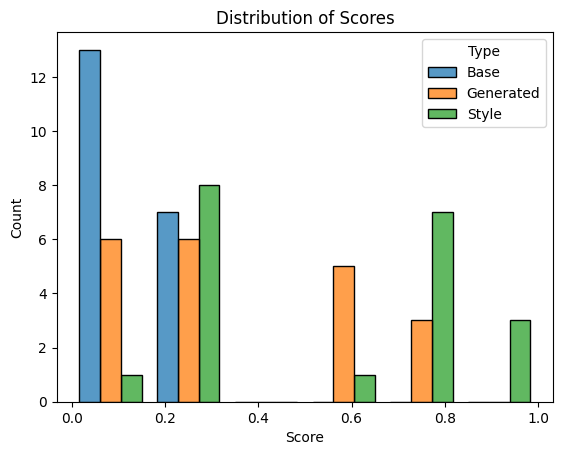

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [38]:
import seaborn as sns
import pandas as pd

# Create clean DataFrame
df = pd.DataFrame({
    'Score': [*base_scores, *generated_scores, *style_scores],
    'Type': ['Base']*len(base_scores) + ['Generated']*len(generated_scores) + ['Style']*len(style_scores)
})

# Plot with seaborn
sns.histplot(data=df, x='Score', hue='Type', multiple="dodge", bins=6, shrink=.8)

plt.title('Distribution of Scores')
plt.show()

In [39]:
yoda_test_text = mdl.lab3.yoda_test_text
tokens = tokenizer(yoda_test_text, return_tensors="pt").to(model.device)

# Get the loglikelihood from the model
with torch.no_grad():
    outputs = model(**tokens)
    logits = outputs.logits[:, :-1]
    targets = tokens.input_ids[:, 1:]
    loss = F.cross_entropy(logits.reshape(-1, logits.size(-1)),
                            targets.reshape(-1))

print(f"Yoda test loglikelihood: {loss.item():.2f}")

Yoda test loglikelihood: 2.68
